In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_fscore_support, make_scorer, recall_score, f1_score, confusion_matrix, precision_score, balanced_accuracy_score
from sklearn.metrics import fbeta_score, classification_report


from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from libs.print_cm import print_cm
from libs.loader import load_malicious, load_jobchange

         

from sklearn.model_selection import learning_curve, validation_curve

In [17]:
#Some labels
ds_labels = {1:'dataset-01: Malicious Hack', 2:'dataset-02: Job Change'}

#Load the two datset
job_data = load_jobchange()
mal_data = load_malicious()


In [12]:


scorer_job = make_scorer(f1_score)
scorer_mal = scorer = make_scorer(recall_score)

dt_job = DecisionTreeClassifier(random_state=0)
dt_mal = DecisionTreeClassifier(random_state=0)




## Hyperparams

In [15]:
def eval_hyperparam(estimator, data, param_name='nothing', range_list=[], scorer=None):
    strat_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    X,y = data
    
    dt_train_scores,dt_test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=range_list,
        scoring=scorer, cv=strat_cv, n_jobs=-1)
    
    train_scores_mean = np.mean(dt_train_scores, axis=1)
    test_scores_mean = np.mean(dt_test_scores, axis=1)
    df_1 = pd.DataFrame({'x':range_list,'train':train_scores_mean,'test':test_scores_mean} )
#     print(df_1)
    return df_1
    

In [63]:
def plot(df_1, metric_name, x_label, title, ds_id, figsize = [7,5], show=False):
    fig = plt.figure(figsize=figsize, facecolor='w')
    axs = fig.add_subplot(111)
    axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=0.75)
    axs.plot(df_1['x'], df_1['test'], label='Validation', linewidth=0.75)
    axs.legend(); axs.set_ylabel("Metric: %s"%metric_name); axs.set_xlabel(x_label)
    title_out = "Decision Tree Hyperparameter:\n%s\n%s"%(title, ds_labels[ds_id])
    axs.set_title(title_out)
    if show:
        plt.show()
    fig.savefig('plots/tree_%d_hyper_%s.png'%(ds_id,x_label),bbox_inches='tight')
    plt.close(fig=fig)

In [67]:
df_1 = eval_hyperparam(dt_job, job_data, param_name='max_depth', range_list=np.linspace(1,25,25), scorer=scorer_job)
df_2 = eval_hyperparam(dt_job, job_data, param_name='min_samples_leaf', range_list=np.linspace(1,1000,30).astype('int32'), scorer=scorer_job)


In [68]:
plot(df_1, 'F1 Score', 'max_depth', 'Max Depth', 2)
plot(df_2, 'F1 Score', 'min_samples_leaf', 'Min Samples Leaf', 2)


In [90]:
df_3 = eval_hyperparam(dt_mal, mal_data, param_name='min_samples_leaf', range_list=np.linspace(1,1000,30).astype('int32'), scorer=scorer_mal)

In [91]:
plot(df_3, 'Recall', 'min_samples_leaf', 'Min Samples Leaf', 1)

In [69]:
#ccp_alpha for Dataset 01 malicious hacks
X_mal_train, y_mal_train = mal_data
path = dt_mal.cost_complexity_pruning_path(X_mal_train, y_mal_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

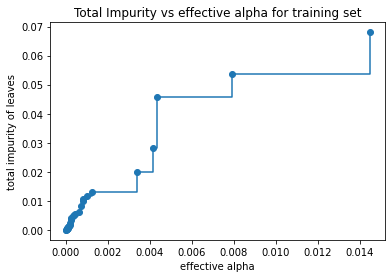

In [70]:
#quick plot of impurities
axs = plt.gca()
axs.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
axs.set_xlabel("effective alpha")
axs.set_ylabel("total impurity of leaves")
axs.set_title("Total Impurity vs effective alpha for training set")

In [71]:
ccp_alphas_range = ccp_alphas[:-1]

In [76]:
def node_counts(ccp_alphas):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=0)
    clfs, x, yn, yd= [],[],[],[]
    plot_data = np.zeros((len(ccp_alphas),2))
    for i in range(len(ccp_alphas)):
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[i])
        clf.fit(X_train, y_train)
        clfs.append(clf)
        x.append( ccp_alphas[i] )
        yn.append(clf.tree_.node_count)
        yd.append(clf.tree_.max_depth)
    return yn, yd


In [87]:
def v_curve(estimator, param_name, range_list, title, show=False):
    strat_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    metric_name ='ccp_alpha'

    mlp_train_scores, mlp_test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=range_list,
        scoring=scorer, cv=strat_cv, n_jobs=-1)
    
    train_scores_mean = np.mean(mlp_train_scores, axis=1)
    test_scores_mean = np.mean(mlp_test_scores, axis=1)
#     print (len(range_list),train_scores_mean.shape,test_scores_mean.shape)
    df_1 = pd.DataFrame({'x':range_list,'train':train_scores_mean,'test':test_scores_mean} )
#     print(df_1)
    
    yn, yd = node_counts(range_list)
    
    
    fig = plt.figure(figsize=[7,5],facecolor='w')
    axs = fig.add_subplot(111)
    
    twin1 = axs.twinx()
    p1, = axs.plot(df_1['x'], df_1['train'], label='Train', linewidth=0.75, marker='.')
    p2, = axs.plot(df_1['x'], df_1['test'], label='Validation', linewidth=0.75, marker='.')
    c_pur = 'Purple'
    p3 = twin1.scatter(df_1['x'], yd, label='Tree depth', c=c_pur, marker='.')
    max_id_series = df_1.idxmax(axis=0)
#     print(max_id_series)
    max_id = max_id_series['test']
#     print(type(max_id_series))
#     print(f"max_id {max_id}")
    best_alpha = df_1.at[max_id, 'x']; alpha_label = 'CCP Alpha %0.5f'%best_alpha
    p4 = axs.axvline(best_alpha, color='g', linewidth=0.85, label=alpha_label)
    
    
    twin1.set_ylabel('Tree Depth')
    twin1.tick_params(axis='y', colors=c_pur)
    twin1.yaxis.label.set_color(c_pur)
    axs.legend(handles=[p1,p2,p3,p4]); axs.set_ylabel("Metric: Recall"); axs.set_xlabel(metric_name)
    axs.set_title(title)
    
    if show:
        plt.show()
    fig.savefig('plots/tree_%d_hyper_%s.png'%(1,metric_name),bbox_inches='tight')
    plt.close(fig=fig)

In [68]:
# depth_stuff = node_counts(ccp_alphas[:15])

In [88]:
ccp_plot_title = "Decision Tree Hyperparameter:\nCCP Alpha (with tree depth)\n%s" % ds_labels[1]
v_curve(dt_mal, 'ccp_alpha', ccp_alphas_range[:15], ccp_plot_title)